# Exploratory Analysis of *Brazilian E-Commerce Public Dataset* by Olist

#### What is *Olist*?

Olist is an e-commerce platform developed to help shopkeepers to sell their products at brazilian marketplaces, such as Americanas, Submarino and Mercado Livre. 

The dataset has more than 100.000 orders that were made between june 2017 and january 2018. 

We all know that brazilians celebrate a lot and they like to gift the people they love. But, what exactly do brazilians usually buy for each occasion? 

---

The main ideia with this notebook is to understand the periods the consumers bought more and which products were more common on each occasion. 

I will also take a look on which payment methods were more susceptible to have the order approved and also, how much the costumers usually spend for each order.

### Libraries

In [5]:
import pandas as pd

In [103]:
#importing the datasets
df_items = pd.read_csv('datasets/olist_order_items_dataset.csv')
df_payments = pd.read_csv('datasets/olist_order_payments_dataset.csv')
df_orders = pd.read_csv('datasets/olist_orders_dataset.csv')
df_products = pd.read_csv('datasets/olist_products_dataset.csv')

In [104]:
#merging the datasets by their keys
df_orders = pd.merge(df_orders, df_items, on='order_id')
df_orders = pd.merge(df_orders, df_payments, on='order_id')
df_orders = pd.merge(df_orders, df_products, on='product_id')

Now that we merged all the datasets we need, let's take a look at them! :-)

In [105]:
columns = ['order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'shipping_limit_date',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm']

In [106]:
# removing the columns we won't need
df_orders.drop(columns=columns, inplace=True)

In [107]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  117601 non-null  object 
 1   customer_id               117601 non-null  object 
 2   order_status              117601 non-null  object 
 3   order_purchase_timestamp  117601 non-null  object 
 4   product_id                117601 non-null  object 
 5   seller_id                 117601 non-null  object 
 6   price                     117601 non-null  float64
 7   freight_value             117601 non-null  float64
 8   payment_sequential        117601 non-null  int64  
 9   payment_type              117601 non-null  object 
 10  payment_installments      117601 non-null  int64  
 11  payment_value             117601 non-null  float64
 12  product_category_name     115903 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory us

Taking a look at the dataframe, we see that *'product_category_name'* has around 1700 NaN values, before dropping them is important to understand their context.

In [108]:
df_orders['product_category_name'].unique()

array(['utilidades_domesticas', 'perfumaria', 'automotivo', 'pet_shop',
       'papelaria', nan, 'moveis_decoracao', 'moveis_escritorio',
       'ferramentas_jardim', 'informatica_acessorios', 'cama_mesa_banho',
       'brinquedos', 'construcao_ferramentas_construcao', 'telefonia',
       'beleza_saude', 'eletronicos', 'bebes', 'cool_stuff',
       'relogios_presentes', 'climatizacao', 'esporte_lazer',
       'livros_interesse_geral', 'eletroportateis', 'alimentos',
       'malas_acessorios', 'fashion_underwear_e_moda_praia',
       'artigos_de_natal', 'fashion_bolsas_e_acessorios',
       'instrumentos_musicais', 'construcao_ferramentas_iluminacao',
       'livros_tecnicos', 'construcao_ferramentas_jardim',
       'eletrodomesticos', 'market_place', 'agro_industria_e_comercio',
       'artigos_de_festas', 'casa_conforto', 'cds_dvds_musicais',
       'industria_comercio_e_negocios', 'consoles_games', 'moveis_quarto',
       'construcao_ferramentas_seguranca', 'telefonia_fixa', 'bebidas

In [109]:
df_nan = df_orders.loc[df_orders['product_category_name'].isnull()]

In [110]:
df_nan['order_status'].unique()

array(['invoiced', 'delivered', 'shipped', 'processing', 'canceled'],
      dtype=object)

In [111]:
df_nan['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card'], dtype=object)

After taking a look on the NaN values, I decided to drop the columns, since they didn't have a pattern (for example, the products without categories corresponds to those Canceled). 

In [112]:
# filtering the dataset
df_orders = df_orders.loc[~df_orders['product_category_name'].isnull()]
df_orders.reset_index(inplace=True)
df_orders.drop(columns='index', inplace=True)

Now that we took care of the NaN values, it's time to take a look on the rest of the columns.

In [113]:
# converting the 'order_purchase_timestamp' to datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])

In [ ]:
# filtering data before 2017
df_orders = df_orders.loc[df_orders['order_purchase_timestamp'].dt.year != 2016]

Data is clean! Time to explore the dataset!

### What were the months with the highest order numbers?

In [136]:
# grouping the number of order per month
order_group = df_orders.groupby(pd.Grouper(key='order_purchase_timestamp', axis=0, 
                      freq='M')).count().reset_index()

In [164]:
order_group[['order_purchase_timestamp', 'order_id']].sort_values(by='order_id', ascending=False).head(10)

,order_purchase_timestamp,order_id
10,2017-11-30,8883
14,2018-03-31,8406
12,2018-01-31,8324
15,2018-04-30,8182
16,2018-05-31,8168
13,2018-02-28,7798
19,2018-08-31,7430
17,2018-06-30,7366
18,2018-07-31,7283
11,2017-12-31,6414


<AxesSubplot:xlabel='order_purchase_timestamp'>

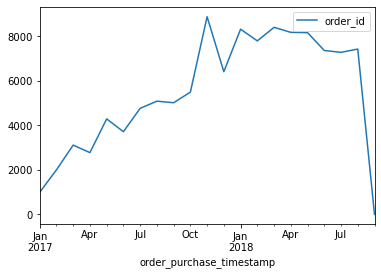

In [137]:
order_group.plot(kind='line', x='order_purchase_timestamp', y='order_id')

### How many confirmed orders per seller do we have?

In [162]:
# counting the number of order per seller
(
    df_orders
    .groupby(['seller_id'])[['order_status', 'seller_id']]
    .count()
).head()

,order_status,seller_id
seller_id,,
0015a82c2db000af6aaaf3ae2ecb0532,3,3
001cca7ae9ae17fb1caed9dfb1094831,241,241
001e6ad469a905060d959994f1b41e4f,1,1
002100f778ceb8431b7a1020ff7ab48f,58,58
004c9cd9d87a3c30c522c48c4fc07416,164,164


In [155]:
#counting the number of confirmed orders per seller
(
    df_orders.loc[df_orders['order_status'] == 'delivered']
    .groupby(['seller_id'])['seller_id']
    .count()
    .sort_values(ascending=False)
).to_frame().head()

,seller_id
seller_id,
4a3ca9315b744ce9f8e9374361493884,2094
6560211a19b47992c3666cc44a7e94c0,2085
1f50f920176fa81dab994f9023523100,2002
cc419e0650a3c5ba77189a1882b7556a,1790
da8622b14eb17ae2831f4ac5b9dab84a,1633
